# getting lesswrong data with novelty proxy

maybe we can use score or baseVotes as a proxy for quality

In [1]:
import json
from pathlib import Path

last_date = '2024-01-01'

## with vanilla requests


pip install markdownify

In [2]:
import requests
from loguru import logger
import time
from dataclasses import dataclass
from markdownify import markdownify



@dataclass
class GreaterWrong:

    """
    This class allows you to scrape posts and comments from GreaterWrong.
    GreaterWrong contains all the posts from LessWrong (which contains the Alignment Forum) and the EA Forum.
    from https://github.com/StampyAI/alignment-research-dataset/blob/main/align_data/sources/greaterwrong/greaterwrong.py#L156
    """

    base_url: str = 'https://www.lesswrong.com'
    start_year: int = 2000
    min_karma: int = -10000
    """Posts must have at least this much karma to be returned."""
    af: bool = False
    """Whether alignment forum posts should be returned"""

    limit = 50
    COOLDOWN = 0.5
    done_key = "url"
    lazy_eval = True
    source_type = 'GreaterWrong'
    _outputted_items = (set(), set())
    

    def make_query(self, after: str):
        return f'''
        {{
            posts(input: {{
                terms: {{
                    excludeEvents: true
                    view: "old"
                    af: {self.af}
                    limit: {self.limit}
                    karmaThreshold: {self.min_karma}
                    after: "{after}"
                    filter: "tagged"
                }}
            }}) {{
                totalCount
                results {{
                    _id
                    title
                    slug
                    pageUrl
                    postedAt
                    modifiedAt
                    emojiReactors
                    score
                    extendedScore
                    baseScore
                    voteCount
                    commentCount
                    wordCount
                    tags {{
                        name
                    }}
                    user {{
                        displayName
                    }}
                    coauthors {{
                        displayName
                    }}
                    af
                    htmlBody
                    allVotes {{
                        authorId
                        _id
                        power
                        afPower
                        isUnvote
                        votedAt
                    }}
                }}
            }}
        }}
        '''

    def fetch_posts(self, query: str):
        res = requests.post(
            f"{self.base_url}/graphql",
            # The GraphQL endpoint returns a 403 if the user agent isn't set... Makes sense, but is annoying
            headers={
                "User-Agent": "Mozilla /5.0 (Macintosh; Intel Mac OS X 10.15; rv:109.0) Gecko/20100101 Firefox/113.0"
            },
            json={"query": query},
        )
        try:
            res.raise_for_status()
        except requests.exceptions.HTTPError:
            logger.error(f"Failed to fetch posts: {res.text}")
            raise

        try:
            return res.json()["data"]["posts"]
        except KeyError:
            raise ValueError(f"Could not parse response: {res.text}")


    @property
    def items_list(self):
        next_date = self.last_date_published
        logger.info("Starting from {next_date}")
        last_item = None
        while next_date:
            logger.info(f"Fetching posts after {next_date}")
            posts = self.fetch_posts(self.make_query(next_date))
            if not posts["results"]:
                return

            # If the only item we find was the one we advanced our iterator to, we're done
            if len(posts["results"]) == 1 and last_item and posts["results"][0]["pageUrl"] == last_item["pageUrl"]:
                return

            for post in posts["results"]:
                if post["htmlBody"]:
                    yield post

            last_item = posts["results"][-1]
            new_next_date = posts["results"][-1]["postedAt"]
            if next_date == new_next_date:
                raise ValueError(f'could not advance through dataset, next date did not advance after {next_date}')

            next_date = new_next_date
            time.sleep(self.COOLDOWN)

    def process_entry(self, item):
        return self.make_data_entry(
            {
                "title": item["title"],
                "text": markdownify(item["htmlBody"]).strip(),
                "url": item["pageUrl"],
                "date_published": self._get_published_date(item),
                "modified_at": item["modifiedAt"],
                "source": self.name,
                "source_type": self.source_type,
                "votes": item["voteCount"],
                "karma": item["baseScore"],
                "tags": [t["name"] for t in item["tags"]],
                "words": item["wordCount"],
                "comment_count": item["commentCount"],
                "authors": self.extract_authors(item),
            }
        )

In [21]:
gw = GreaterWrong()
gw.last_date_published = '2023-01-01'

import pandas as pd
from tqdm.auto import tqdm

cache_file = Path('output/01greaterwrong.json')
cache_file.parent.mkdir(parents=True, exist_ok=True)

https://www.lesswrong.com/graphiql

In [25]:
if cache_file.exists():
    with cache_file.open() as f:
        posts = json.load(f)
    print(f'Loaded {len(posts)} posts from cache')
else:
    
    posts = []
    for post in tqdm(gw.items_list):
        posts.append(post)

    cache_file.write_text(json.dumps(posts, indent=2))
len(posts)

Loaded 9346 posts from cache


9346

In [109]:
df = pd.DataFrame(posts)
df.drop(columns=['emojiReactors'], inplace=True)
for col in ['postedAt', 'modifiedAt']:
    df[col] = pd.to_datetime(df[col])
p_file = Path('output/01greaterwrong.json')
df.to_parquet(p_file)
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9346 entries, 0 to 9345
Data columns (total 18 columns):
 #   Column         Non-Null Count  Dtype              
---  ------         --------------  -----              
 0   _id            9346 non-null   object             
 1   title          9346 non-null   object             
 2   slug           9346 non-null   object             
 3   pageUrl        9346 non-null   object             
 4   postedAt       9346 non-null   datetime64[ns, UTC]
 5   modifiedAt     9346 non-null   datetime64[ns, UTC]
 6   score          9346 non-null   float64            
 7   extendedScore  7034 non-null   object             
 8   baseScore      9346 non-null   int64              
 9   voteCount      9346 non-null   int64              
 10  commentCount   9346 non-null   int64              
 11  wordCount      9346 non-null   int64              
 12  tags           9346 non-null   object             
 13  user           9270 non-null   object           

In [110]:
df = df[['title', 'pageUrl', 'modifiedAt', 'htmlBody', 'score', 'baseScore', 'voteCount', 'wordCount', 'slug']]
df = df[
    (df['modifiedAt'] > last_date)
    & (df['voteCount'] > 10)
     ].sort_values('score', ascending=False)

In [111]:
df.describe()

,score,baseScore,voteCount,wordCount
count,2385.000000,2385.000000,2385.000000,2385.000000
mean,0.018153,71.339203,36.330398,2963.753040
std,0.104511,68.800261,38.117311,3937.558236
min,-0.017480,-50.000000,11.000000,0.000000
25%,0.001787,32.000000,16.000000,730.000000
50%,0.003472,50.000000,24.000000,1660.000000
75%,0.007957,86.000000,40.000000,3445.000000
max,3.236718,677.000000,499.000000,57468.000000


/media/wassname/SGIronWolf/projects5/bs_writing_detector/.venv/lib/python3.11/site-packages/pandas/core/arraylike.py:396: RuntimeWarning: invalid value encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


<Axes: >

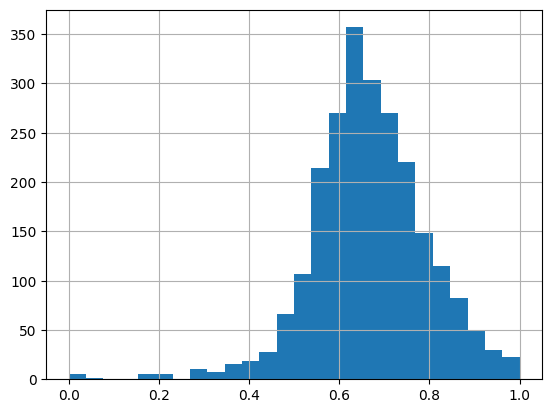

In [141]:
import numpy as np
v = np.log(df['baseScore']+0.001)
v = (v - v.min())/v.max() - 1 
v = np.clip(v, 0, 1)
df['novelty'] = v
df['novelty'].hist(bins=26)

In [144]:
def to_markdown(row: dict) -> str:
    md = markdownify(row["htmlBody"]).strip()

    return f"""---
title: {row['title']}
date: {row['modifiedAt']}
url: {row['pageUrl']}
novelty: {row['novelty']}
score: {row['score']}
baseScore: {row['baseScore']}
voteCount: {row['voteCount']}
---
{md}
"""


for i in range(5):
    for ii in [i, -i-1]:
        row = df.iloc[i]
        s = to_markdown(row)
        f = Path(f'../samples/{row["modifiedAt"].year}_lw_{row["slug"]}.md')
        f.write_text(s)
        print(f"{f} {row['score']:>4}")

../samples/2025_lw_parkinson-s-law-and-the-ideology-of-statistics-1.md 3.236717700958252
../samples/2025_lw_parkinson-s-law-and-the-ideology-of-statistics-1.md 3.236717700958252
../samples/2025_lw_what-s-the-short-timeline-plan.md 2.114389657974243
../samples/2025_lw_what-s-the-short-timeline-plan.md 2.114389657974243
../samples/2025_lw_the-laws-of-large-numbers.md 1.2245203256607056
../samples/2025_lw_the-laws-of-large-numbers.md 1.2245203256607056
../samples/2025_lw_the-intelligence-curse.md 1.2061121463775635
../samples/2025_lw_the-intelligence-curse.md 1.2061121463775635
../samples/2025_lw_human-study-on-ai-spear-phishing-campaigns.md 0.9995136260986328
../samples/2025_lw_human-study-on-ai-spear-phishing-campaigns.md 0.9995136260986328
